<a href="https://colab.research.google.com/github/ActualWolverine/Machine-Learning-Basics/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq duckduckgo_search
!pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
from fastcore.all import *
from duckduckgo_search import ddg_images

In [ ]:
from fastai.vision.all import *
from fastdownload import download_url

In [ ]:
def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [ ]:
urls = search_images('cat', max_images=1)
dest = "cat1.jpg"
download_url(urls[0], dest)

Searching for 'cat'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Path('cat1.jpg')

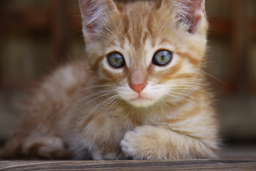

In [ ]:
cat = Image.open(dest)
cat.to_thumb(256, 256)

Searching for 'dog'


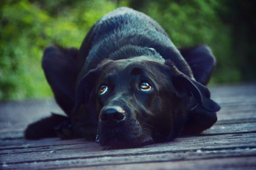

In [ ]:
download_url(search_images('dog', max_images=1)[0], 'dog.jpg')
Image.open('dog.jpg').to_thumb(256, 256)

make a model that takes an input of a cat image or dog image, and returns "cat" or "dog".

To do this we are going to get a bunch of cat photos, labeled as cat, and dog photos labeled as dog.

we are going to feed the labeled images to a machine learning model. The model is going to get an image and predict whether it is a cat or a dog. It's prediction will be compared with the label, and the parameters of the model will be tweaked based on whether it was right or wrong.



step 1: get a bunch of cat and dog images

In [ ]:
searches = 'cat', 'dog'

searches

('cat', 'dog')

In [ ]:

path = Path('cat_or_not')
from time import sleep
for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(o))
  sleep(10)
  download_images(dest, urls=search_images(f'baby {o}'))
  sleep(10)
  download_images(dest, urls=search_images(f'adult {o}'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cat'
Searching for 'baby cat'
Searching for 'adult cat'
Searching for 'dog'
Searching for 'baby dog'
Searching for 'adult dog'


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#0) []

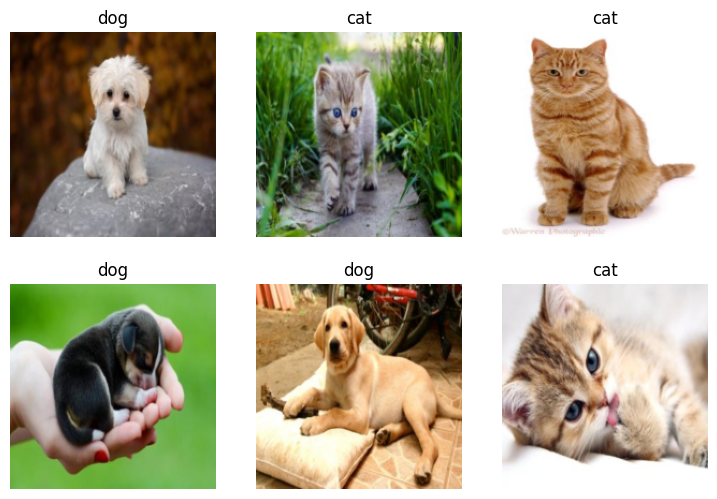

In [ ]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=2),
                get_y=parent_label,
                item_tfms=[Resize(192, method='squish')]).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.755818,0.489317,0.218750,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.122700,0.109748,0.031250,00:28
1,0.072242,0.019233,0.000000,00:38
2,0.048191,0.012146,0.000000,00:28


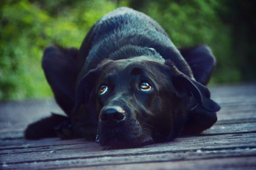

In [ ]:
dog = PILImage.create("dog.jpg")
dog.to_thumb(256, 256)

In [ ]:
is_cat,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: dog.
Probability it's a cat: 0.0000


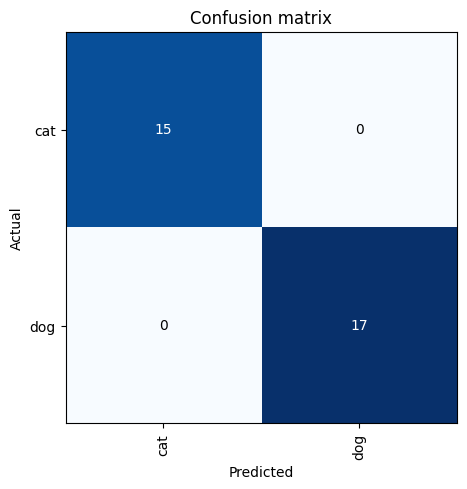

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

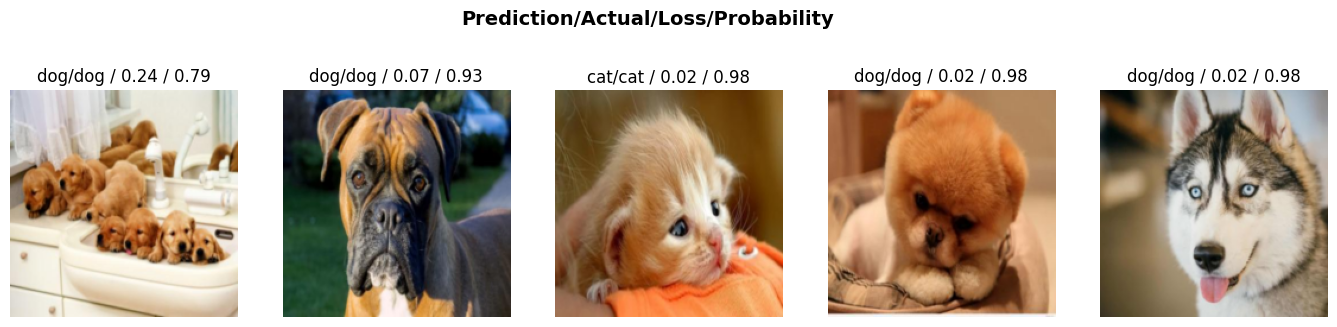

In [ ]:
interp.plot_top_losses(5, nrows=1, figsize=(17, 4))